In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import norm, poisson
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage

from deep_uncertainty.models import GaussianNN, PoissonNN, DoublePoissonNN, NegBinomNN
from deep_uncertainty.random_variables import DoublePoisson

plt.rcParams['figure.dpi'] = 600

In [2]:
def rotate_mnist_tensor(x: torch.Tensor, degrees: float | int) -> torch.Tensor:
    to_tensor = ToTensor()
    to_pil = ToPILImage()

    return to_tensor(to_pil(x).rotate(degrees))

In [3]:
from scipy.optimize import fmin

def hdi(distribution, credMass=0.95):
    
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distribution.ppf(credMass + lowTailPr) - distribution.ppf(lowTailPr)

    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    return distribution.ppf(HDIlowTailPr), distribution.ppf(credMass + HDIlowTailPr)

In [4]:
to_tensor = ToTensor()
to_pil = ToPILImage()
test = MNIST(root="./data/mnist", train=False, download=True, transform=to_tensor)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



In [7]:
gaussian_exp = "mnist_gaussian_1.0"
poisson_exp = "mnist_poisson"
neg_binom_exp = "mnist_negative_binomial"
double_poisson_exp = "mnist_double_poisson_1.0"

gaussian_nn = GaussianNN.load_from_checkpoint(f"../../chkp/old/{gaussian_exp}/version_0/epoch=39.ckpt", map_location="cpu")
poisson_nn = PoissonNN.load_from_checkpoint(f"../../chkp/old/{poisson_exp}/version_0/epoch=39.ckpt", map_location="cpu")
neg_binom_nn = NegBinomNN.load_from_checkpoint(f"../../chkp/old/{neg_binom_exp}/version_0/epoch=39-v1.ckpt", map_location="cpu")
double_poisson_nn = DoublePoissonNN.load_from_checkpoint(f"../../chkp/old/mnist_double_poisson_1.0_v2/version_0/epoch=39.ckpt", map_location="cpu")

TypeError: GaussianNN.__init__() missing 1 required positional argument: 'backbone_kwargs'

In [98]:
all_gaussian_preds = []
all_poisson_preds = []
all_nbinom_preds = []
all_dpo_preds = []

angles = [0, 45]
num_angles = len(angles)

with torch.inference_mode():
    for digit in range(0, 10):

        mask = test.targets == digit
        instances_of_target = test.data[mask]
        num_images = len(instances_of_target)

        gaussian_preds = torch.zeros(num_angles, num_images, 2)
        poisson_preds = torch.zeros(num_angles, num_images, 1)
        neg_binom_preds = torch.zeros(num_angles, num_images, 2)
        double_poisson_preds = torch.zeros(num_angles, num_images, 2)

        for i, angle in enumerate(angles):
            for j, tensor in enumerate(instances_of_target):
                rotated = rotate_mnist_tensor(tensor, angle).view(1, 1, 28, 28)
                gaussian_y_hat = gaussian_nn._predict_impl(rotated).squeeze()
                gaussian_preds[i, j, :] = gaussian_y_hat

                poisson_y_hat = poisson_nn._predict_impl(rotated).squeeze()
                poisson_preds[i, j, :] = poisson_y_hat

                nbinom_y_hat = neg_binom_nn._predict_impl(rotated).squeeze()
                neg_binom_preds[i, j, :] = nbinom_y_hat

                dpo_y_hat = double_poisson_nn._predict_impl(rotated).squeeze()
                double_poisson_preds[i, j, :] = dpo_y_hat
        
        all_gaussian_preds.append(gaussian_preds)
        all_poisson_preds.append(poisson_preds)
        all_nbinom_preds.append(neg_binom_preds)
        all_dpo_preds.append(double_poisson_preds)

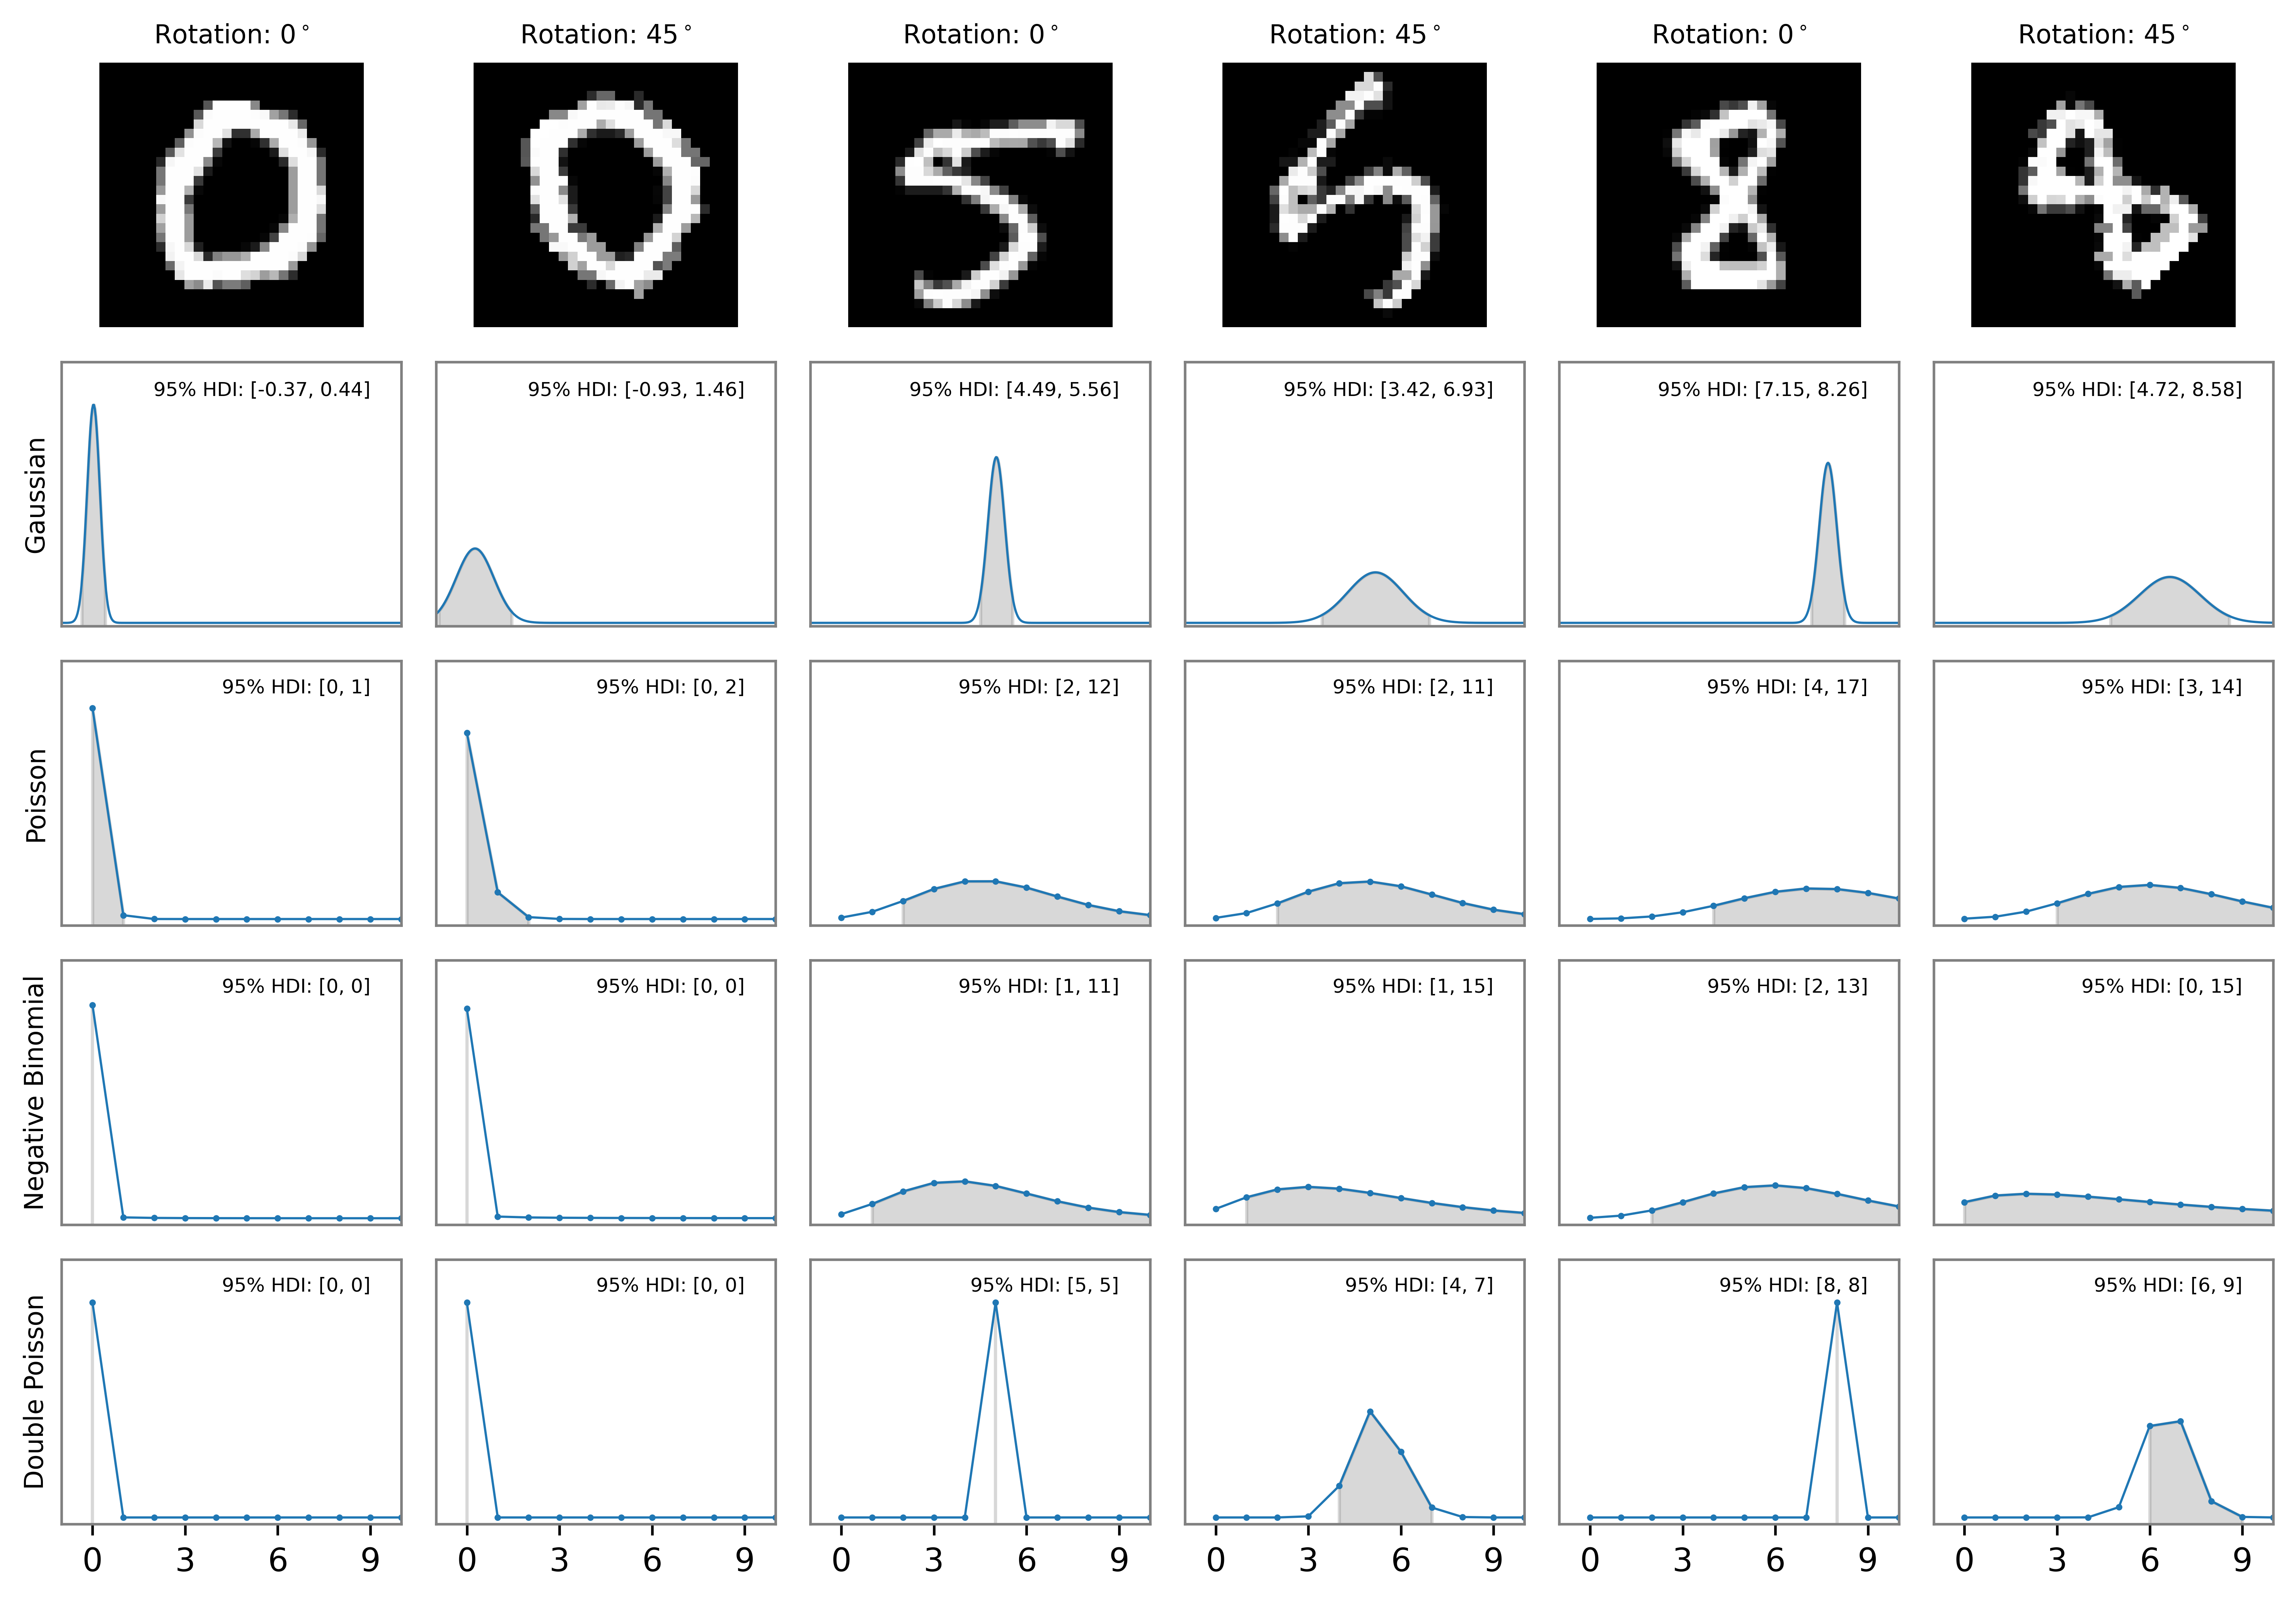

In [103]:
from scipy.stats import nbinom

digits = [0, 5, 8]
cont_support = np.linspace(-2, 12, 500)
disc_support = np.arange(0, 20)

fig, axs = plt.subplots(5, len(angles) * len(digits), figsize=(10, 7), sharey="row")
for i, digit in enumerate(digits):

    mask = test.targets == digit
    instances_of_target = test.data[mask]

    avg_gaussian_preds = all_gaussian_preds[digit].mean(dim=1)
    avg_poisson_preds = all_poisson_preds[digit].mean(dim=1)
    avg_nbinom_preds = all_nbinom_preds[digit].mean(dim=1)
    avg_double_poisson_preds = all_dpo_preds[digit].mean(dim=1)

    im_tensor = instances_of_target[7] / 255.
    tensors = [rotate_mnist_tensor(im_tensor, angle) for angle in angles]

    for ax, tensor, angle in zip(axs[0, i*2:i*2+2], tensors, angles):
        ax.set_title(f"Rotation: ${angle}^\circ$", fontsize=8)
        ax.imshow(to_pil(tensor), cmap="gray")
        ax.axis("off")

    
    for j, angle in enumerate(angles):
        
        idx = 2*i + j
        gauss_mu, var = avg_gaussian_preds[j].numpy()
        gauss_dist = norm(loc=gauss_mu, scale=math.sqrt(var))
        lam = avg_poisson_preds[j].detach().numpy()
        poiss_dist = poisson(mu=lam)
        nbinom_mu, alpha = avg_nbinom_preds[j].numpy()
        nbinom_var = nbinom_mu + alpha * nbinom_mu**2
        p = nbinom_mu / nbinom_var
        n = nbinom_mu**2 / (nbinom_var - nbinom_mu)
        nbinom_dist = nbinom(n=n, p=p)
        dpo_mu, phi = avg_double_poisson_preds[j].numpy()
        dpo_dist = DoublePoisson(dpo_mu, phi)

        axs[1, idx].plot(cont_support, gauss_dist.pdf(cont_support), linewidth=0.7)
        lower, upper = hdi(gauss_dist)
        axs[1, idx].set_ylim(-0.03, 2.3)
        axs[1, idx].text(9, 2, f"95% HDI: [{lower:.2f}, {upper:.2f}]", horizontalalignment='right', fontsize=6)
        axs[1, idx].fill_between(
            x=cont_support,
            y1=-0.1,
            y2=gauss_dist.pdf(cont_support),
            where=(cont_support >= lower) & (cont_support <= upper),
            color="gray",
            alpha=0.3,
        )
        axs[1, idx].set_xticks([])
            
        axs[2, idx].plot(disc_support, poiss_dist.pmf(disc_support), ".-", linewidth=0.7, markersize=2)
        lower, upper = hdi(poiss_dist)
        axs[2, idx].set_ylim(-0.03, 1.2)
        axs[2, idx].text(9, 1.05, f"95% HDI: [{int(lower[0])}, {int(upper[0])}]", horizontalalignment='right', fontsize=6)
        axs[2, idx].fill_between(
            x=disc_support,
            y1=-0.1,
            y2=poiss_dist.pmf(disc_support),
            where=(disc_support >= lower) & (disc_support <= upper),
            color="gray",
            alpha=0.3,
        )
        axs[2, idx].set_xticks([])

        axs[3, idx].plot(disc_support, nbinom_dist.pmf(disc_support), ".-", linewidth=0.7, markersize=2)
        lower, upper = hdi(nbinom_dist)
        axs[3, idx].set_ylim(-0.03, 1.2)
        axs[3, idx].text(9, 1.05, f"95% HDI: [{int(lower)}, {int(upper)}]", horizontalalignment='right', fontsize=6)
        axs[3, idx].fill_between(
            x=disc_support,
            y1=-0.1,
            y2=nbinom_dist.pmf(disc_support),
            where=(disc_support >= lower) & (disc_support <= upper),
            color="gray",
            alpha=0.3,
        )
        axs[3, idx].set_xticks([])

        axs[4, idx].plot(disc_support, dpo_dist.pmf(disc_support), ".-", linewidth=0.7, markersize=2)
        lower, upper = hdi(dpo_dist, 0.95)
        axs[4, idx].set_ylim(-0.03, 1.2)
        axs[4, idx].text(9, 1.05, f"95% HDI: [{lower}, {upper}]", horizontalalignment='right', fontsize=6)
        axs[4, idx].fill_between(
            x=disc_support,
            y1=-0.1,
            y2=dpo_dist.pmf(disc_support),
            where=(disc_support >= lower) & (disc_support <= upper),
            color="gray",
            alpha=0.3,
        )
        axs[4, idx].set_xticks([0, 3, 6, 9])

        if idx == 0:
            axs[1, idx].set_ylabel("Gaussian DNN", fontsize=8)
            axs[2, idx].set_ylabel("Poisson DNN", fontsize=8)
            axs[3, idx].set_ylabel("NB DNN", fontsize=8)
            axs[4, idx].set_ylabel("DDPN (Ours)", fontsize=8)

for ax in axs.ravel()[6:]:
    ax.set_xlim(-1, 10)
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

fig.savefig("mnist_regression_corrupt_input.pdf", format="pdf")

plt.tight_layout()
plt.show()

In [9]:
import pandas as pd

metric_cols = ["mae", "mse"]
gaussian_metrics = pd.read_csv(f"../logs/{gaussian_exp}/version_1/metrics.csv").iloc[-1][metric_cols]
poisson_metrics = pd.read_csv(f"../logs/{poisson_exp}/version_1/metrics.csv").iloc[-1][metric_cols]
nbinom_metrics = pd.read_csv(f"../logs/{neg_binom_exp}/version_2/metrics.csv").iloc[-1][metric_cols]
double_poisson_metrics = pd.read_csv(f"../logs/{double_poisson_exp}/version_0/metrics.csv").iloc[-1][metric_cols]

metrics_df = pd.DataFrame(data=[gaussian_metrics, poisson_metrics, nbinom_metrics, double_poisson_metrics], index=["Gaussian", "Poisson", "Negative Binomial", "Double Poisson"])
metrics_df

,mae,mse
Gaussian,0.162101,0.154879
Poisson,0.458571,0.542286
Negative Binomial,1.063429,1.748286
Double Poisson,0.110714,0.192714


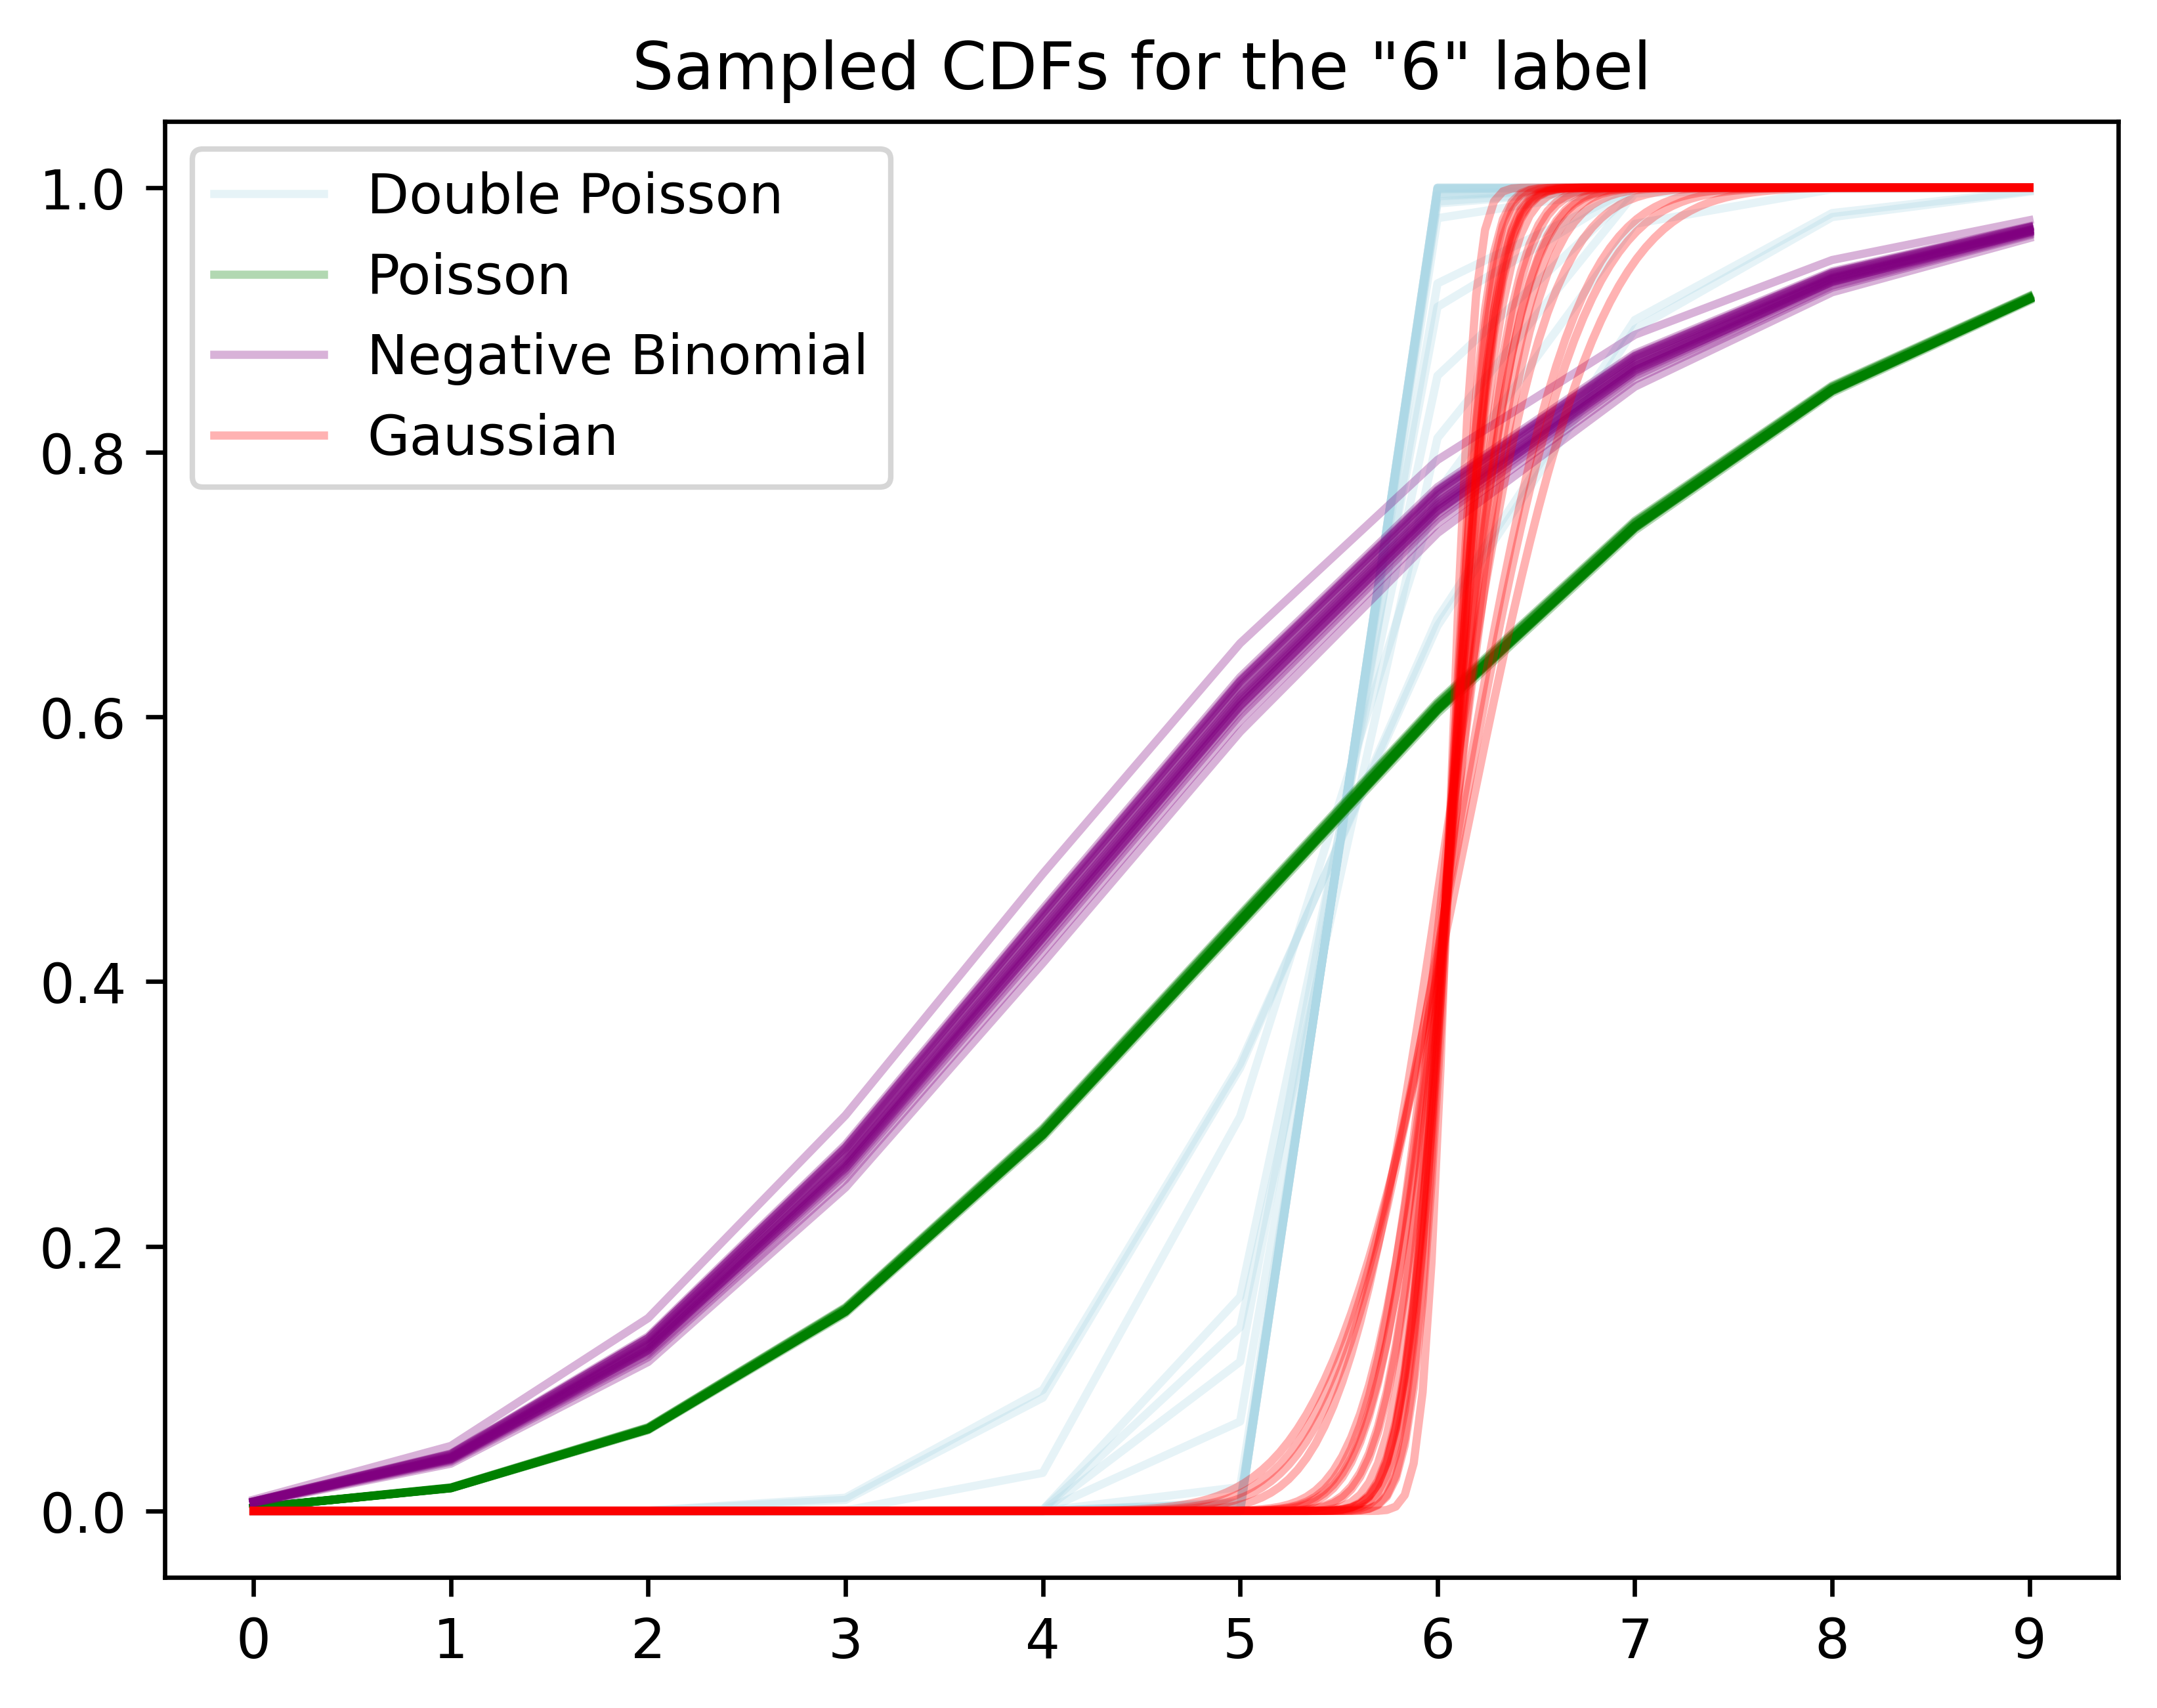

In [10]:
from matplotlib.lines import Line2D

sample = np.random.randint(0, len(instances_of_target), size=20)

mu_vals, phi_vals = torch.split(all_double_poisson_preds[0][sample], [1, 1], dim=-1)
dpo_dist = DoublePoisson(mu_vals.flatten().detach().numpy(), phi_vals.flatten().detach().numpy())

mu_vals, var_vals = torch.split(all_gaussian_preds[0][sample], [1, 1], dim=-1)
gauss_dist = norm(loc=mu_vals.flatten().detach().numpy(), scale=torch.sqrt(var_vals).flatten().detach().numpy())

mu_vals, alpha_vals = torch.split(all_neg_binom_preds[0][sample], [1, 1], dim=-1)
mu_vals = mu_vals.flatten().detach().numpy()
alpha_vals = alpha_vals.flatten().detach().numpy()
var_vals = mu_vals + alpha_vals * mu_vals**2
p = mu_vals / var_vals
n = mu_vals**2 / (var_vals - mu_vals)
nbinom_dist = nbinom(n=n, p=p)

lam_vals = all_poisson_preds[0][sample].flatten().detach().numpy()
poiss_dist = poisson(mu=lam_vals)

plt.title("Sampled CDFs for the \"6\" label")
plt.plot(disc_support, dpo_dist.cdf_vals[:10], alpha=0.3, c='lightblue')
plt.plot(disc_support, poiss_dist.cdf(disc_support.reshape(-1, 1)), alpha=0.3, c='green')
plt.plot(disc_support, nbinom_dist.cdf(disc_support.reshape(-1, 1)), alpha=0.3, c='purple')
plt.plot(cont_support, gauss_dist.cdf(cont_support.reshape(-1, 1)), alpha=0.3, c='red')
plt.xticks(disc_support)
plt.legend(
    handles=[
        Line2D([0], [0], color='lightblue', alpha=0.3, label="Double Poisson"),
        Line2D([0], [0], color='green', alpha=0.3, label="Poisson"),
        Line2D([0], [0], color='purple', alpha=0.3, label="Negative Binomial"),
        Line2D([0], [0], color='red', alpha=0.3, label="Gaussian")
    ]
)
plt.show()